# Google Summer of Code 2023

I have been selected as a contributor under the organization [NumFOCUS](https://numfocus.org) for the Google Summer of Code 2023 program. I will be working on _developing better tools to interpret complex Bambi regression models_. More details about the project can be found [here](https://summerofcode.withgoogle.com/projects/#6187085698856448). This blog post will be a summary of the community bonding period and the progress made over the first two weeks of the program.

Timeline of events:

* Community Bonding Period (May 4th - 28th)
* Week 1 (May 29th - June 4th)
* Week 2 (June 5th - June 11th)

## Community Bonding Period

The community bonding period is a time for students to get to know their mentors and organizations, and to change / finalize project details. I have been in contact with my mentors Tomás Capretto and Osvaldo Martin via Slack and GitHub. A goal of mine throughout the community bonding period was not only to get to know my mentors, but also to familiarize myself with the Bambi codebase before coding officially began. To achieve this, I read through the codebase attempting to understand how the different modules interact with one another. Additionally, I read through the Bambi documentation to understand how the different models are implemented, and any additional functionality provided the library. After familarizing myself with the codebase at a high level, I decided to get a jumpstart on the project deliverables for week 1 through 4. Below is a table of the deliverables for the entire project timeline.

|Week|Deliverable|
|---|---|
|1|Review plot_cap() design and relevant Bambi codebase. Discuss grammar of graphics libraries with mentors. Identify any open GitHub issues regarding plot_cap() that would restrict development.|
|2|Implement predictions at the observational level for plot_cap(), and add tests, and documentation.|
|3|Design of how plot_comparisons() and plot_slopes() can re-utilize the plot_cap() code and be incorporated into the Bambi codebase.|
|4|Begin plot_comparisons() implementation|
|5|Deliver working example of plot_comparisons() for a simple Bambi model, and open draft PR.|
|6|Continue plot_comparisons() implementation. Deliver example on a complex model.|
|7|Write tests, examples, and documentation for plot_comparisons(), and open PR.|
|8|Begin plot_slopes() implementation.|
|9|Deliver working example of plot_slopes() for a simple Bambi model, and open draft PR.|
|10|Continue plot_slopes() implementation. Deliver example on a complex model.|
|11|Write tests, examples, and documentation for plot_slopes(), and open PR.|
|12|Review plot_cap(), plot_comparisons(), and plot_slopes() code. Ensure documentation and examples are correct, and tests pass.|
|13|Final submission. This week is a buffer period for code review, unexpected difficulties, and ensuring documentation and added examples are accurate and comprehensive.|

# Progress

## `plot_cap` using posterior predictive samples

Predictions at the observation level for `plot_cap` were implemented in [PR 668](https://github.com/bambinos/bambi/pull/668). By default, `plot_cap` uses the posterior distribution to visualize some mean outcome parameter of a a GLM. However, the posterior predictive distribution can also be plotted by specifying `pps=True` where `pps` stands for _posterior predictive samples_ of the response variable. Upon completion of the PR above, an example showing the functionality of `plot_cap` was added to the Bambi documentation in [PR 670](https://github.com/bambinos/bambi/pull/670).

## Modularization of the `plots` sub-package

Completing the week one and two deliveribles early on in the program allowed me to spend more time on the design of the `plots` sub-package and implementation of `plot_comparisons`. For the design of the `plots` sub-package, I decided to create five different modules, each with a specific purpose. The modules are as follows:

* `create_data.py` - creates the data called by the functions in the `effects.py` and `comparisons.py` modules.
* `effects.py` - contains the functions (`predictions`, `comparisons`, `slopes`) that are used to create the dataframe that is passed to the plotting functions and or user when called standalone. 
* `utils.py` - contains commonly used functions that are called by multiple modules in the `plots` sub-package.
* `plotting.py` - contains the plotting functions (`plot_predictions`, `plot_comparisons`, `plot_slopes`) that are used to generate the plots for the user.
* `plot_types.py` - determines the plot types (numeric or categorical) for the the `plotting` module.

The modularization of the `plots` sub-package will allow for easier maintenance and testing of the codebase and offers re-usability of code using OOP principles. The modularization of code happened during the initial development stages of the `plot_comparisons` function. 

## Comparisons: `plot_comparisons`

Predictive comparisons refers to the predictions made by a model for different covariate values while holding one or more variable constant. For example, we may be interested in the following quantity, "how does the probability of survival (outcome) change if a passenger travels in 1st class vs. 3rd class? given a certain age and sex?" Thus, the objective of the comparisons plotting functionality is to plot comparisons on the y-axis against values of one or more covariates on the x-axis
 
Currently, `plot_comparisons` only works when a user explicitly passes the contrast covariate and its value, and the conditional covariate and values they would like to condition on.

In [1]:
#| code-fold: true
import numpy as np
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison, comparisons

In [4]:
#| code-fold: true
dat = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", 
    index_col=0
)

dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["SexCode"] = pd.Categorical(dat["SexCode"], ordered=True)
dat = dat.dropna(axis=0, how="any")

In [5]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="bernoulli"
)
titanic_idata = titanic_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234
)

Modeling the probability that Survived==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


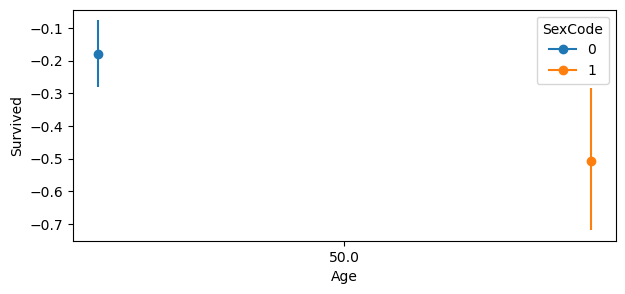

In [9]:
# user can also pass a dict into conditional to define the 
# values used for the conditional variables
fig, ax = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast={"PClass": [1, 3]},
    conditional={"Age": [50], "SexCode": [0, 1]}
)
fig.set_size_inches(7, 3)

Comparing an individual of `Age`= $50$ and `SexCode` = $0$, moving `PClass` from $1$ to $3$ decreases the probability of survival by about $0.2$. For `SexCode` = $1$, the probability of survival decrease by nearly $0.5$. 

## Next Steps

The next weeks will involve adding:

* default contrast and conditional values so the user does not have to explicitly pass them.
* unit-level comparisons which uses the observed data instead of creating a hypothetical dataset to compute comparison estimates.
* an average by argument to allow the user to marginalize over a subset of covariates.